# Exploring a simple Kalman Filter example

### Carolyn P Johnston, March 6, 2016

A Kalman Filter is an algorithm to estimate the state of an evolving system, described by continuous state variables, in the presence of inherent noise in the system's true state and in the measurement system. The classic example of an application of Kalman Filters is to navigation; a KF might be used to estimate updates to a plane's location, when the measurement systems are imperfect and there is a bit of unmodelled turbulence in the atmosphere. 

The KF algorithm was developed in the early 1960s, and there have been many variants and extensions built since the first form was introduced. The purpose of this note is to introduce the most basic example, so that the user can play with it and understand the influence of all of the parameters. 

## The ant on the line, and the nearsighted student with a ruler

In this simple problem, assume that there is an ant, sitting at a location on a line; a grad student wants to measure the ant's location over time by measuring its position with a ruler at intervals of a second. The ant has no inclination to move from one moment to the next, but at each time interval, a random gust of wind might come along in either direction and blow the ant to a new location on the line. This is one source of random error in the system.

Another source of error is that the student is nearsighted, and makes random errors in measuring the ant's location with the ruler.

You are given some knowledge about the likely force of the random gusts of wind (the random noise in the *state* process), and of the size of the errors that the nearsighted student makes (the random noise in the *measurement* process). It also makes sense to assume that the ant doesn't particularly care about getting back to the place where it started, and would be happy to remain exactly where it is right now, if only the wind would leave it in peace.

The problem to be solved is this: get estimates of the ant's actual locations at each time-step, using all the given information about the system.

The diagram below shows the sample Kalman Filter's structure. The KF begins with the ant's (known) initial position $x_0$, and an initial value for the error variance $P_0$, shown in blue at left. At the first time step, the ant's new position $x_1$ (in brown), is obtained by adding the 'wind' offset, $q_1$, to its previous position $x_0$. The $x_k$ for $k>0$ are "hidden" values, because we can only estimate them, not observe their true values.

The student then makes the first observation, $z_1$, which is assumed to consist of the true value of $x_1$, plus a "ruler error" term, $e_1$. The resulting measurement, in black, is not hidden; the student observes it. The goal of the KF is to use the assumptions about the systematic and random components of the problem,  together with the observation $z_1$, to get optimal estimates of the ant's true position $x_1$.

The process is repeated at the next time step, $k=2$. Only the state at time step $k=1$ influences the solution at $k=2$; given the state at time $k=1$, the state at time $k=2$ is independent of the states at all the time steps that came previously. This is the property that defines a Markov chain, of which the KF is an example. 

![alt text](SimpleKF.png "Diagram of Simple Kalman Filter example")


This code simulates the ant's position on the line, and calculates its estimated location using the Kalman Filter. The 'state function' component of the problem is the identity; the expected value of the location of the ant at each time step is the same as its true location at the previous time step, i.e., $E[X_k] = X_{k-1}$. If $Q$ is a constant representing the standard deviation of the motion of the ant due to the gusts of wind, and we assume that the ant's motion is normally distributed with 0 mean, we actually have $X_k = X_{k-1} + q_k$ for the *true* location of the point $X_k$ at time step $k$, where $q_k$ has the distribution $\text{N}(0, Q)$. 

What else do we have to work with? We have the measurements $z_k$ of the ant's position given by the student. We know that these measurements aren't quite right, but we have done some controlled experiments with the student, and have determined that her measurement errors are roughly normally distributed, with standard deviation $R$.  We know that at every time step we get a measurement $z_k$ of the ant's location that is corrupted with some Gaussian noise: $z_k = X_k + e_k$, where $e_k$ has the distribution $\text{N}(0, R)$.

In general, we don't have to assume that the wind gusts and the student's errors are normally distributed; but if we do know that, then we get some guarantees of statistical optimality for the Kalman Filter estimates.

For this simulation, the initial position of the point is 0, and the state we want to estimate is its position at each time $t$. The KF also requires that we maintain estimates of the error variances $P_k$, the variance of the difference between the predicted state (our best guess at the location of the ant before the student takes a measurement -- this is always going to be the ant's last position!), and the final estimated state taking the ruler measurement into account. 

In order to kick off the KF algorithm, we need not only to have initial values for $X_0$, but also for the error covariance $P_0$.

The Kalman Filter simulation and estimation code, below, takes the following arguments:

- **trueQ**: The *true* variance of the process noise, used in the simulation (wind gusts, default value .001 units);
- **Q**: our guess at the variance of the process noise, used in the KF solution. Default value also .001 units;
- **trueR**: The *true* variance of the measurement noise, used in the simulation (nearsighted student's ruler errors, default value .01 units); 
- **R**: our guess at the variance of the measurement noise, used in the KF solution. Default value also .01 units;
- **initX**: initial position of the ant (default value 0);
- **initP**: initial value of the error covariance (default value 1.0) -- I will discuss the effect of this parameter later; 
- **numsamps**: the length in seconds of the simulation.

In [102]:
%matplotlib inline
from math import sqrt
import numpy as np
import numpy.random as rdm
import matplotlib.pyplot as ppt
import pylab as pb

def KF(
    trueQ,
    trueR,
    numsamps,
    initX,
    initP,
    Q,
    R): 
    """
    Simulates a KF estimate over samples of a single point
    moving on a line with process noise given by trueQ.
    numsamps: number of time steps to simulate
    trueQ, trueR: vars of process & measurement error used to generate simulation
    initX: initial value of X
    initP: initial value of P
    Q: value of process noise used in KF
    R: value of measurement noise used in KF
    """
    trueX = np.zeros(numsamps)
    trueX[0] = initX

    Xestimates = np.zeros(numsamps)
    Xestimates[0] = initX # value of X_0, set by user

    P_estimates = np.zeros(numsamps)
    P_estimates[0] = initP # value of P_0, set by user
    
    # generate numsamps samples of process noise with variance trueQ
    # generate numsamps samples of measurement noise with variance trueR
    trueQsamps = rdm.randn(numsamps)*sqrt(trueQ)
    trueRsamps = rdm.randn(numsamps)*sqrt(trueR)
    trueMeasure = np.zeros(numsamps)
    
    for ii in range(1, numsamps):
        prevk = ii-1

        # generate true value of X_k = X_k_prev + q_k
        trueX[ii] = trueX[prevk] + trueQsamps[ii]        
        
        #Apply Phi -- propagate the previous estimate & covar to the current k 
        x_k_prior = PropagateToNextState(Xestimates[prevk])
        P_k_prior = PropagateToNextCovariance(P_estimates[prevk], Q)
        
        #Apply H -- map x_k_prior to the measurement space
        pred_z_k = PropagateToMeasurement(x_k_prior)

        # get the true measurement
        z_k = GetTrueMeasurement(trueX[ii], trueRsamps[ii])
        trueMeasure[ii]=z_k
        
        # get the Kalman gain
        K_k = GetKalmanGain(P_k_prior, R)

        Xestimates[ii]=CorrectPredictedState(x_k_prior, z_k, pred_z_k, K_k)
        P_estimates[ii]=CorrectPredictedCovariance(P_k_prior, K_k)
        
    return trueMeasure, trueX, Xestimates, P_estimates

def KF1(
    trueQ=.001, \
    trueR=.01, \
    numsamps=100, \
    initX = 0.0,\
    initP = 1.0,\
    Q=.001, \
    R=.01): 
    """
    Simulates a KF estimate over samples of a single point
    moving on a line with process noise given by trueQ.
    numsamps: number of time steps to simulate
    trueQ, trueM: vars of process & measurement error used to generate simulation
    initX: initial value of X
    initP: initial value of P
    Q: value of process noise used in KF
    R: value of measurement noise used in KF
    """
    
    trueMeasure, trueX, Xestimates, P_estimates = KF(trueQ, trueR, numsamps, initX, initP, Q, R)
    PlotMe(trueMeasure, trueX, Xestimates, P_estimates)
    return trueX, Xestimates, P_estimates

def KF2(
    trueQ=.001, \
    trueR=.01, \
    numsamps=100, \
    initX = 0.0,\
    initP = 1.0,\
    Q=.001, \
    R=.01): 
    """
    Simulates a KF estimate over samples of a single point
    moving on a line with process noise given by trueQ.
    numsamps: number of time steps to simulate
    trueQ, trueM: vars of process & measurement error used to generate simulation
    initX: initial value of X
    initP: initial value of P
    Q: value of process noise used in KF
    R: value of measurement noise used in KF
    """
    
    trueMeasure, trueX, Xestimates, P_estimates = KF(trueQ, trueR, numsamps, initX, initP, Q, R)
    PlotMyCovar(trueMeasure, trueX, Xestimates, P_estimates)
    return trueX, Xestimates, P_estimates

def PlotMe(tmeas, tstates,pstates, covars):
    zeros = np.zeros(len(tstates))
    stdevs = [sqrt(covar) for covar in covars]
    ppt.plot(tmeas, "r-", tstates, "k-", pstates , "b-", zeros, "g-")
    pb.show()
    ppt.plot(tstates-pstates, "b-", stdevs, "g-", zeros, "r-")
    pb.show()
    
def PlotMyCovar(tmeas, tstates,pstates, covars):
    zeros = np.zeros(len(tstates))
    stdevs = [sqrt(covar) for covar in covars]
    ppt.plot(tstates-pstates, "b-", stdevs, "g-", zeros, "r-")
    pb.show()
    
def PropagateToNextState(Xprev, Phi = 1.0):
    return Phi*Xprev

def PropagateToNextCovariance(Pprev, Q, Phi = 1.0):
    return Phi*Pprev*Phi + Q

def GetTrueMeasurement(trueX, m_noise, H=1.0):
    return H*trueX + m_noise

def PropagateToMeasurement(Xprior, H=1.0):
    return Xprior*H

def GetKalmanGain(Pprior, M, H=1.0):
    return (Pprior*H)/(H*Pprior*H + M)

def CorrectPredictedState(Xprior, z_k, pred_z_k, K_k):
    return Xprior + K_k*(z_k - pred_z_k)

def CorrectPredictedCovariance(Pprior, K_k, H=1.0):
    return (1.0 - K_k*H)*Pprior


## First simulation: the ruler error, and the wind gust strength, are correctly estimated

In the first simulation, the size of the measurement (ruler) and process (wind) errors are correctly estimated --  the values of the noise variances **Q** and **R** are set equal to the true, simulated values of **trueQ** and **trueR**. 

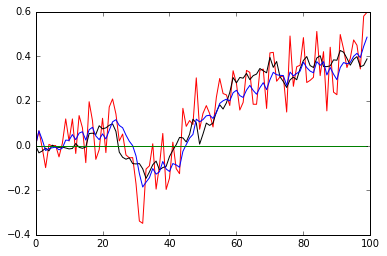

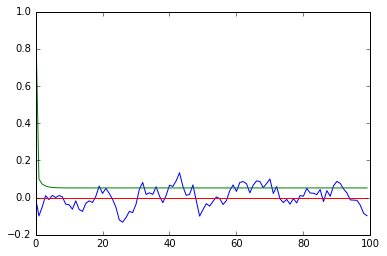

In [103]:

# Run the first simulation
# Return values:
# true_X: the simulated (truth) values of the ant's position
# X_estimates, the ant's position as predicted by the KF
# P_estimates, the error covariances as calculated by the KF 
true_X, X_estimates, P_estimates = KF1()

### Interpreting the above plots

#### Top plot

The red curve is the series of measurements by the grad student: the black curve is the true location of the ant at each time step: and the blue is the location of the ant as predicted by the Kalman filter. 

The green horizontal line at the top is the ant's initial position ($x_0=0$ in all of the simulations).

Notice that the estimated location curve is much smoother than the measured location curve.

#### Bottom plot

This plot analyzes the corrections made by the KF system. Recall that the corrections (in blue) are the differences between the predicted and estimated values of position, and that for this system the predicted position is always the last position that the ant was in; so this curve has values $X_k - X_{k-1}$. 

Remember in the first section, when I said that the KF system needs to keep track of the error covariances, and that we need to initialize the error covariance **initP** in the same way we do the initial location, **initX**? The green curve is the time series of estimated error covariances $P_k$. 

Notice that, although we set **initP** to be quite large (with a value of 1.0) compared to the actual noise in the system, the estimates of P drop very quickly to a value nearer to the true difference between the predicted and actual error.


## Second simulation: we underestimate the size of the student's measurement error

We'll set the true measurement variance **trueR** to be .01, but our assumed value of the measurement variance is **R**=.001.   

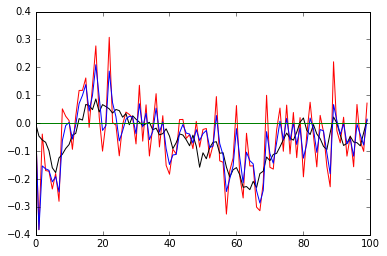

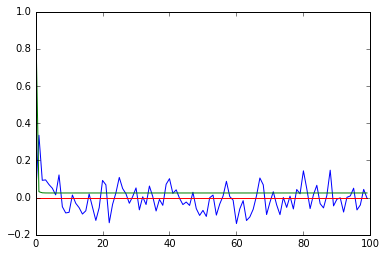

In [104]:
# Run the second simulation: trueM = .01, M = .001
# all other values are the same as above
true_X, X_estimates, P_estimates = KF1(trueR = .01, R = .001)

### Interpreting the above plots

#### Top plot

The red curve is the series of measurements by the grad student, and the blue is the location of the ant as predicted by the Kalman filter. The estimate (blue curve) is sticking closer to the measurements (red curve) than it ought to, because by underestimating the measurement error, we've told it to trust the measurements too much. 


#### Bottom plot

This plot analyzes the corrections made by the KF system. Recall that the blue curve has values $X_k - X_{k-1}$, and the green curve is the KF's estimate of the error variance.  

If I had set the value of measurement error correctly, the green line should look like a standard deviation curve for the blue (estimated) curve. Because I underestimated the measurement error, the standard deviation curve underestimates the true standard error.  

## Third simulation: we overestimate the size of the student's measurement error

We'll set the assumed value of the student's measurement noise, **R** to be 0.1 this time, and the true value **trueR** will be .01 as usual.

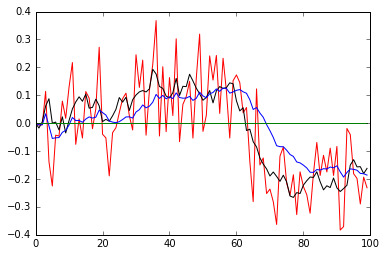

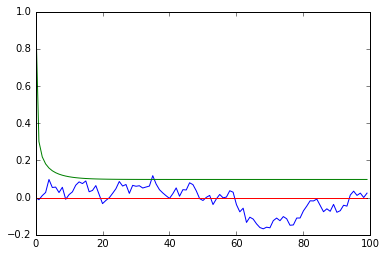

In [105]:
# Run the third simulation: trueM = .01, M = 0.1
# all other values are the same as above
true_X, X_estimates, P_estimates = KF1(trueR = .01, R = 0.1, numsamps=100)

### Interpreting the above plots

#### Top plot

The red curve is the series of measurements by the grad student, and the blue is the location of the ant as predicted by the Kalman filter. The estimate (blue curve) is much smoother than in any of the previous examples, because the KF is reluctant to trust the measurements -- we've told the KF that the measurements are bigger than they are. Therefore, the estimated position is slow to follow trend changes in the black line (true ant positions). 

#### Bottom plot

This plot analyzes the corrections made by the KF system. Recall that the blue curve has values $X_k - X_{k-1}$, and the green curve is the KF's estimate of the error variance (difference between predicted and estimated locations of the ant).  

Because I overestimated the measurement error, the standard deviation curve overestimates the true standard error. Note also that the standard deviation curve is slower to drop to its limiting value from its (overly large) initial value -- again because the system doesn't trust the measurements.

## Fourth simulation: Simulation with wind gust strength underestimated by the Kalman Filter.

In the previous simulation, we tinkered with the values of *measurement* noise, to see what effect that had on the estimated values of the ant's locations. This amounted to under- or over-estimating the accuracy of the student's measurements of the ant's position, using the ruler.

In the next two simulations, we'll under and over estimate the values of the *process* noise -- i.e., we'll assume that the wind is either stronger or weaker than it really is. 

In this simulation, we'll set the true process noise **trueQ** to be .001, but assume in the KF that **Q** is actually .0001. 

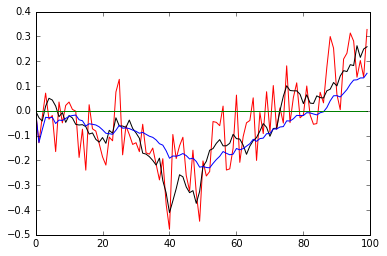

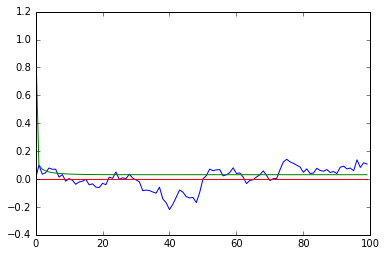

In [106]:
# Run the fourth simulation: trueQ = .001, Q = 0.0001
# all other values are the same as above
true_X, X_estimates, P_estimates = KF1(trueQ = .001, Q = 0.0001, numsamps=100)

### Interpreting the above plots

#### Top plot

The red curve is the series of measurements by the grad student (in this example, we've assumed the correct value for the measurement errors -- .01), and the blue is the location of the ant as predicted by the Kalman filter. The estimated ant location (blue curve) is quite smooth, because we have told the KF that the wind is pushing the ant around less than it actually is. Therefore, the blue curve is having a hard time following the jumpy measured (red) curve around, and the red curve is doing a better job of tracking the actual ant location.   

#### Bottom plot

This plot analyzes the corrections made by the KF system. Recall that the blue curve has values $X_k - X_{k-1}$, and the green curve is the KF's estimate of the error variance, which is too low in this case.

## Fifth simulation: Simulation with wind gust strength overestimated by the Kalman Filter.

In this simulation, we'll overestimate the values of process noise -- i.e., we'll assume that the wind is stronger than it actually is. We'll set the true process noise **trueQ** to be .001, but assume in the KF that **Q** is .1. 



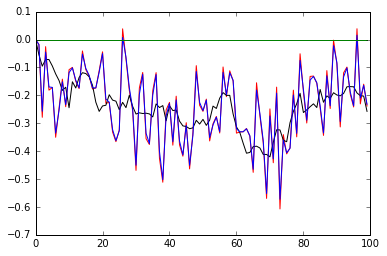

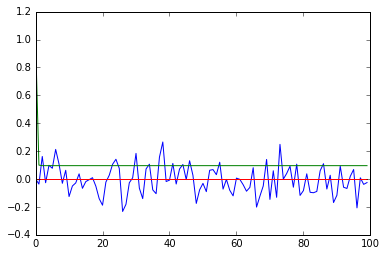

In [107]:
# Run the fifth simulation: trueQ = .001, Q = 0.1
# all other values are the same as above
true_X, X_estimates, P_estimates = KF1(trueQ = .001, Q = 0.1, numsamps=100)

### Interpreting the above plots

#### Top plot

The red curve is the series of measurements by the grad student, and the blue is the location of the ant as predicted by the Kalman filter. The estimated ant location (blue curve) follows the red curve closely. Since we've told the KF to expect a lot of wind, the KF is willing to believe that the ant's position is changing wildly. However, the ant's true location is a much smoother curve, because the wind is not really all that strong.

#### Bottom plot

This plot analyzes the corrections made by the KF system. Recall that the blue curve has values $X_k - X_{k-1}$, and the green curve is the KF's estimate of the error variance, which overestimates the error variance in the limit. 

## A final note: the effect of the initial covariance $P_0$ on the solution

#### Upshot: it doesn't have a significant effect for very long.

In the following simulation, we'll assume again that the true measurement and process errors are equal to the $R$ and $Q$ that we set. In the first plot, we set initP to be larger than the limiting value of P, and in the second, we set initP to be smaller than the limiting value of P.

In the plots below, the green curves show the estimated values of the error covariances. In both cases, we find that the estimates of the error covariance $P$ drop very quickly to within 1% of their limiting value, 0.00270156 -- within 9 samples for both simulations. So, after that point, the initial value $P_0$ has no effect on the solution -- it is really just there to kick off the estimation process. (Note that it's actually the square root of .00270156 that is being plotted in green).

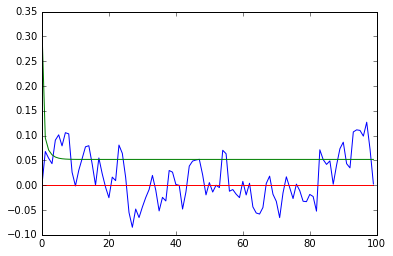

In [108]:
# Run a simulation with initP too large
true_X, X_estimates, P_estimates = KF2(initP=0.1)

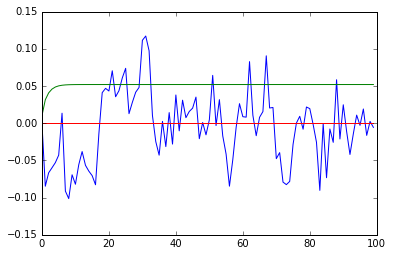

In [109]:
# Run a simulation with initP way too small
true_X, X_estimates, P_estimates = KF2(initP=.0001)

#### This time it really is a final note: What is that limiting value of the covariance P, anyway?

Note that in each plot in the last two examples, the green curve (the square roots of the estimated covariances at each time step $k$) quickly settles down and becomes nearly constant. What is the limiting value of the estimated covariance? For this simple example, the answer is easy to find analytically.

The Kalman Filter is a recursive algorithm that operates on matrices when the state is multivariate. You can find the general multivariate algorithm [here on Wikipedia](https://en.wikipedia.org/wiki/Kalman_filter#Overview_of_the_calculation).

I've simplified the general Kalman Filter mathematics in this example, by making the state transition matrix $F_k$, and the measurement operator $H_k$, extremely simple (both are just multiplication by 1, so they all drop out of the formulas). In addition, the process noise variance $Q_k$ and the measurement noise $R_k$ are actually just scalars, because I made the state 1-dimensional. In my simple example, the scalars $Q_k$ and $R_k$ never change with k (so I just call them Q and R); in the most general case you can allow all of those to vary with $k$. This makes the KF an extremely flexible algorithm.

For this example, if you use the Wikipedia formula to calculate $P_{k|k}$ as a function of $P_{k-1|k-1}$, you'll get the following (considerably simplified) formula for the covariance as a function of the time step $k$:

![alt text](KF-eq1.png "Equation 1")

The limiting value of the covariance $P$ has to be a *fixed point* $p$ of that update formula, so we want to solve the equation:

![alt text](KF-eq2.png "Equation 2")

The quadratic formula gives the general solution (only the positive value makes sense):

![alt text](KF-eq3.png "Equation 3")

In this case, since $Q=.001$ and $M=.01$, we get: $p=.0027015$, as we observed. The square root of that value, or .05197, is the horizontal asymptote of the green curve in the two plots above. 